# Training a model with Keras and SqueezeNet

My final model creation is done with Keras. It offers more control over the model and how it's trained. Keras runs on top of TensorFlow, so I'm doing all the training on GColab.

In [20]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import *
from keras import optimizers
import matplotlib.pyplot as plt

I define the size of the images that I will be using to train the model: 32px*32px

In [21]:
image_width = 32
image_height = 32
num_classes = 20

The first iteration of the model is going to be one with a single Flatten (images go from 3 dimensions: height x width x rgb) to a single dimension. 

Then Dense (the important part of the logistic regression: multiplying the 3072 inputs and the 20 outputs, each input is connected to every output):
Dense -> y = a[0]*x[0] + a[1]*x[1] + ... + a[3071]*x[3071] + b*

Finally a softmax function is applied, this is a non-linear operation that gets applied to the output, this makes a *multinomial* logistic regression classifier. It tells us which classes the data points belong to, depending on which side of the line they fall.

In [22]:
model = Sequential()
model.add(Flatten(input_shape=(image_height, image_width, 3)))
model.add(Dense(num_classes))
model.add(Activation("softmax"))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 3072)              0         
                                                                 
 dense_4 (Dense)             (None, 20)                61460     
                                                                 
 activation_3 (Activation)   (None, 20)                0         
                                                                 
Total params: 61,460
Trainable params: 61,460
Non-trainable params: 0
_________________________________________________________________


Then it's time to compile the model, giving it the **loss function** to use: categorical cross-enthropy. An **optimizer** implements the Stochastic Gradient Decent, the learning rate is a very important hyperparameter, after some tinkering, 0.001 seems to be a good step size. I also add the accuracy metric as it's easier to read than the default loss value.

In [23]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              metrics=["accuracy"])

Loading the data and taking one of them to check if the loading and resizing works correctly:

In [24]:
images_dir = "/content/drive/MyDrive/Colab Notebooks/snacks"
train_data_dir = images_dir + "/train/"
val_data_dir = images_dir + "/val/"
test_data_dir = images_dir + "/test/"

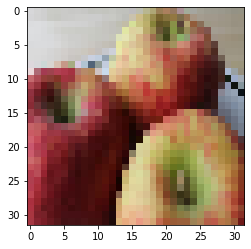

In [25]:
from keras.preprocessing import image
img = image.load_img(
  train_data_dir + "apple/cecd90f5d46f57b0.jpg", 
  target_size=(image_width, image_height))

plt.imshow(img)

It's important to transform the PIL images to a NumPy array, as it's the one that Keras can train with. The arrays consist of numbers between 0 and 255 (as they're pixels). But it's customary (and good practice) to normalize the data before training with it. Feature scaling will have a mean of 0. So the function normalize_pixels(image) creates a new range from -1 to 1.

In [26]:
x = image.img_to_array(img)

print(x)

def normalize_pixels(image):
    return image / 127.5 - 1

x = image.img_to_array(img)
x = normalize_pixels(x)
x = np.expand_dims(x, axis=0)

print("Normalized: ", x)

[[[215. 215. 217.]
  [211. 211. 211.]
  [207. 207. 207.]
  ...
  [152. 150. 137.]
  [148. 146. 133.]
  [149. 147. 132.]]

 [[213. 213. 215.]
  [210. 210. 210.]
  [207. 207. 207.]
  ...
  [157. 150. 134.]
  [153. 146. 130.]
  [153. 146. 128.]]

 [[219. 220. 222.]
  [220. 221. 223.]
  [218. 219. 221.]
  ...
  [156. 149. 133.]
  [152. 145. 129.]
  [153. 146. 130.]]

 ...

 [[172.  50.  65.]
  [131.  34.  41.]
  [ 95.  23.  27.]
  ...
  [193. 121.  81.]
  [181.  90.  63.]
  [140.  68.  46.]]

 [[168.  54.  64.]
  [123.  32.  41.]
  [118.  33.  40.]
  ...
  [177. 118.  74.]
  [163.  64.  45.]
  [136.  49.  39.]]

 [[165.  55.  66.]
  [132.  35.  46.]
  [120.  29.  38.]
  ...
  [172. 116.  67.]
  [155.  89.  55.]
  [111.  25.  24.]]]
Normalized:  [[[[ 0.6862745   0.6862745   0.7019608 ]
   [ 0.654902    0.654902    0.654902  ]
   [ 0.62352943  0.62352943  0.62352943]
   ...
   [ 0.19215691  0.17647064  0.07450986]
   [ 0.16078436  0.14509809  0.04313731]
   [ 0.1686275   0.15294123  0.035294

It's time to test the model with the first prediction. As the model didn't learn anything yet, it should give a number close to 0.05 or 5% per class. This might sound useless, but it helps with visualizing if there are any errors until now. As training a model that's already buggy wouldn't be useful:

In [27]:
pred = model.predict(x)
print(pred)

[[0.03312709 0.03664171 0.03461097 0.05820881 0.02576856 0.05648158
  0.15344732 0.03297386 0.08870466 0.06590625 0.04703789 0.01189364
  0.01468125 0.01893063 0.00823254 0.02741101 0.01923922 0.15265453
  0.06553201 0.04851644]]


To make the loading of images easier, Keras provides generators to check that the data is correct, also it loads the folders correctly. In this case the train generator has shuffle=True while the other two are False. This is because during training I don't want the model to learn specific order of the images. Meanwhile during testing I want them in order, to check that the answers are correct.

In [28]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(preprocessing_function=normalize_pixels)

batch_size = 64

train_generator = datagen.flow_from_directory(
                    train_data_dir,
                    target_size=(image_width, image_height),
                    batch_size=batch_size,
                    class_mode="categorical",
                    shuffle=True)

val_generator = datagen.flow_from_directory(
                    val_data_dir,
                    target_size=(image_width, image_height),
                    batch_size=batch_size,
                    class_mode="categorical",
                    shuffle=False)

test_generator = datagen.flow_from_directory(
                    test_data_dir,
                    target_size=(image_width, image_height),
                    batch_size=batch_size,
                    class_mode="categorical",
                    shuffle=False)

Found 4860 images belonging to 20 classes.
Found 955 images belonging to 20 classes.
Found 986 images belonging to 20 classes.


And this is the generator output:

In [29]:
x, y = next(train_generator)
print(x.shape)
print(y.shape)

(64, 32, 32, 3)
(64, 20)


The shape of the x tensor is (64, 32, 32, 3) because it contains 64 RGB images of 32x32 px.

It's time to run the untrained model on the entire test set and verify that both the model and generators work. At this point the accuracy should be around 5%, as the output is basically a random guess for the class:

In [30]:
model.evaluate(test_generator, steps=len(test_generator))

16/16 [==============================] - 5s 278ms/step - loss: 3.3259 - accuracy: 0.0477


[3.3259057998657227, 0.04766734316945076]

After checking that the infrastructure is in place, we can start performing the first training.
1- Ignore the warnings from the PIL library, as it just generates noise
2- Call the fit_generator on the model, I'll do this for 5 epochs (pass through all the training images)

In [31]:
model.fit(train_generator, 
          steps_per_epoch=len(train_generator),
          validation_data=val_generator,
          validation_steps=len(val_generator),
          epochs=5,
          workers=16)

Epoch 1/5
76/76 [==============================] - 22s 252ms/step - loss: 3.0873 - accuracy: 0.1053 - val_loss: 3.0500 - val_accuracy: 0.1246
Epoch 2/5
76/76 [==============================] - 15s 179ms/step - loss: 2.6937 - accuracy: 0.1979 - val_loss: 3.0777 - val_accuracy: 0.1277
Epoch 3/5
76/76 [==============================] - 15s 181ms/step - loss: 2.4914 - accuracy: 0.2720 - val_loss: 3.1122 - val_accuracy: 0.1120
Epoch 4/5
76/76 [==============================] - 15s 183ms/step - loss: 2.3251 - accuracy: 0.3278 - val_loss: 3.1387 - val_accuracy: 0.1058
Epoch 5/5
76/76 [==============================] - 15s 179ms/step - loss: 2.2058 - accuracy: 0.3591 - val_loss: 3.1780 - val_accuracy: 0.1204


The model is already better with an accuracy of around ~12%. But how come the training accuracy is much higher? **Overfitting:** the model isn't learning to classify images, it just remembers the combinations of pixels on every image, instead of what they represent.

To improve this we can add another logistic regression to it. This makes for a very simple neural network! The first dense layer connects 3072 inputs to 500 hidden neurons, which then connect to the 20 outputs. The activation function on the dense layer is a rectified linear unit, basically *y = max(0, x)*. 

In [32]:
model = Sequential()
model.add(Flatten(input_shape=(image_height, image_width, 3)))
model.add(Dense(500, activation="relu"))  # new dense layer
model.add(Dense(num_classes))
model.add(Activation("softmax"))

It's time to compile the new model and train it, this time 3 epochs will be enough:

In [33]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              metrics=["accuracy"])

model.fit(train_generator, 
          steps_per_epoch=len(train_generator),
          validation_data=val_generator,
          validation_steps=len(val_generator),
          epochs=3,
          workers=16)

Epoch 1/3
76/76 [==============================] - 20s 246ms/step - loss: 3.2285 - accuracy: 0.1130 - val_loss: 3.0682 - val_accuracy: 0.1288
Epoch 2/3
76/76 [==============================] - 16s 199ms/step - loss: 2.3962 - accuracy: 0.3144 - val_loss: 3.1816 - val_accuracy: 0.1403
Epoch 3/3
76/76 [==============================] - 16s 198ms/step - loss: 1.8965 - accuracy: 0.4613 - val_loss: 3.1770 - val_accuracy: 0.1602


This type of model: logistic regression and fully connected neural networks won't give a much better output than this 16% accuracy, this is because it destroys the spatial nature of the data. 

Going convolutional:
As described before, flattening removes the depth dimension of the input data (red, green, and blue). It's better to treat these numbers as an indivisible unit: the pixel's color. A convolution is like a window (in this case 3x3px) that moves through the image, and the weight is applied to the 9 pixels in the window. We could say it's a translation invariant, as the weights are the same no matter where we look. Let's now define the new sizes for the images:

In [34]:
image_width = 224
image_height = 224
num_classes = 20

And create the model. In this case we have the same Dense and Activation("softmax") layers as before, but without the Flatten layer. Instead, I'm using a Conv2D layer with the following parameters:
- Number of filters: I start with 32, up to 256 on the last layer. Each filter learns to detect a unique pattern
- The size of the kernel window: 3, which is interpreted as (3, 3)
- The padding: this adds a padding of one empty pixel around the image, so the output size remains the same (check the hand in to see why is this)
- A non-linear activation function: still using ReLU

In [35]:
model = Sequential()
model.add(Conv2D(32, 3, padding="same", activation="relu",
                 input_shape=(image_height, image_width, 3)))
model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPooling2D(2))
model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPooling2D(2))
model.add(Conv2D(128, 3, padding="same", activation="relu"))
model.add(Conv2D(128, 3, padding="same", activation="relu"))
model.add(MaxPooling2D(2))
model.add(Conv2D(256, 3, padding="same", activation="relu"))
model.add(Conv2D(256, 3, padding="same", activation="relu"))
model.add(GlobalAveragePooling2D())
model.add(Dense(num_classes))
model.add(Activation("softmax"))

Compile the new model:

In [36]:
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              metrics=["accuracy"])

Train the new model:

In [37]:
images_dir = "/content/drive/MyDrive/Colab Notebooks/snacks/"
train_data_dir = images_dir + "train/"
val_data_dir = images_dir + "val/"
test_data_dir = images_dir + "test/"

def normalize_pixels(image):
    return image / 127.5 - 1

from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
  preprocessing_function=normalize_pixels)

batch_size = 64

train_generator = datagen.flow_from_directory(
                    train_data_dir,
                    target_size=(image_width, image_height),
                    batch_size=batch_size,
                    class_mode="categorical",
                    shuffle=True)

val_generator = datagen.flow_from_directory(
                    val_data_dir,
                    target_size=(image_width, image_height),
                    batch_size=batch_size,
                    class_mode="categorical",
                    shuffle=False)

test_generator = datagen.flow_from_directory(
                    test_data_dir,
                    target_size=(image_width, image_height),
                    batch_size=batch_size,
                    class_mode="categorical",
                    shuffle=False)

index2class = {v:k for k,v in 
  train_generator.class_indices.items()}

Found 4860 images belonging to 20 classes.
Found 955 images belonging to 20 classes.
Found 986 images belonging to 20 classes.


Keras returns a History object with important metrics such as loss. These history metrics can be combined in an array, and then append them. To give the accuracy a boost, I'm also using annealing. To lower the loss we must also lower the learning rate. Doing this by hand (using the optimizer in the second line below) is called **manual learning rate annealing**:

In [50]:
import keras.backend as K
K.set_value(model.optimizer.lr, 
            K.get_value(model.optimizer.lr) / 10)

histories = []
history = model.fit(
  train_generator, 
  steps_per_epoch=len(train_generator),
  validation_data=val_generator,
  validation_steps=len(val_generator),
  epochs=3,
  workers=16)
histories.append(history)

Epoch 1/3
76/76 [==============================] - 1976s 26s/step - loss: 2.5735 - accuracy: 0.2056 - val_loss: 2.5919 - val_accuracy: 0.2094
Epoch 2/3
76/76 [==============================] - 1954s 26s/step - loss: 2.5476 - accuracy: 0.2183 - val_loss: 2.5861 - val_accuracy: 0.2073
Epoch 3/3
76/76 [==============================] - 2045s 27s/step - loss: 2.5386 - accuracy: 0.2216 - val_loss: 2.5876 - val_accuracy: 0.2147


I ran the previous cell twice (this is a cloud machine and it disconnects sometimes, and each run takes >1.5 hours). Every time it runs it appends the history, so now I can create a plot to visualize the loss and accuracy after all the epochs:

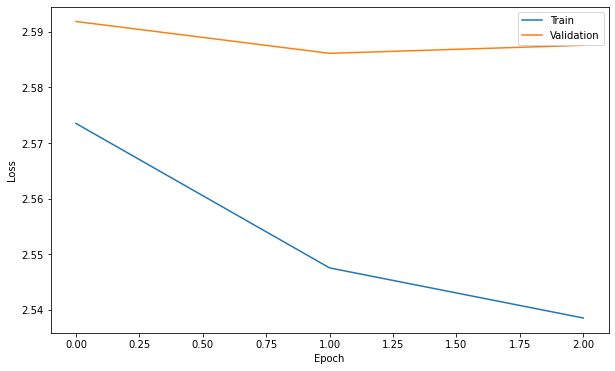

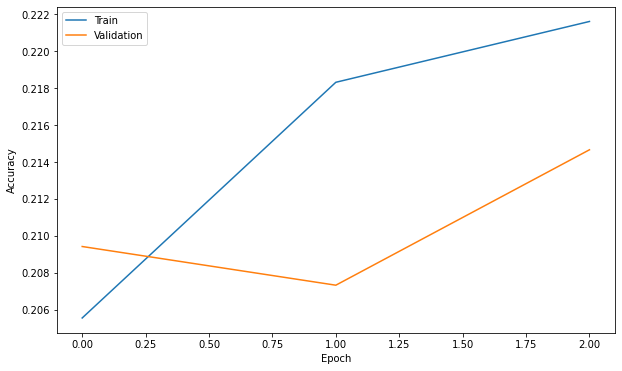

In [52]:
def combine_histories():
    history = { 
        "loss": [], 
        "val_loss": [], 
        "accuracy": [],
        "val_accuracy": []
    }
    
    for h in histories:
        for k in history.keys():
            history[k] += h.history[k]
    return history

history = combine_histories()

def plot_loss(history):
    fig = plt.figure(figsize=(10, 6))
    plt.plot(history["loss"])
    plt.plot(history["val_loss"])
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["Train", "Validation"])
    plt.show()

plot_loss(history)

def plot_accuracy(history):
    fig = plt.figure(figsize=(10, 6))
    plt.plot(history["accuracy"])
    plt.plot(history["val_accuracy"])
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(["Train", "Validation"])
    plt.show()

plot_accuracy(history)

So far I've gotten around 22% accuracy in 6 epochs (the graph only plots the last 2). This is a lot better than where I started, but there are still some improvements to be made if I want to compete with CreateML or TuriCreate. Unfortunately I run out of time. So my final model has 22% accuracy.